<h1>Baseline with ResNet50</h1>

* Features: 15-second mel spectrograms, augmented with pitch shift and pink noise
* Architecture: ResNet50
* Model: Fine-tuning of IMAGENET1K_V2 weights
* Loss function: CrossEntropyLoss
* Target: 29 musicmap supergenres

In [1]:
# Imports
import os

from PIL import Image

import torch
import torchvision
import torchvision.models as models
from torchvision import transforms
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms.functional as Fvision
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot

import pandas as pd
import networkx as nx
from bs4 import BeautifulSoup
from collections import defaultdict
from pyvis.network import Network
import json
from tabulate import tabulate
from collections import Counter
import tqdm

Set the working directory

In [2]:
working_directory = '/Volumes/Sonnet_SSD/DocumentsS/GitHub/neuromatch_spectrograms/'

<h1>Shortest Path Matrix</h1>

One of our evaluation metrics will be the average shortest path. To compute this, we'll need to generate a shortest path matrix from the musicmap graph.

Since this process involves a lot of code that we'll be reusing with various models, I've saved the code as a separate, importable file.

**Note that we don't actually need to do this for (just) predicting supergenres**

In [3]:
from musicmap_graph_creator import create_musicmap_graph, compute_shortest_paths_between_classes_nx

musicmap_graph = create_musicmap_graph(
    primary_edge_weight = 1, 
    secondary_edge_weight = 2,
    backlash_edge_weight = 3,
    supergenre_edge_weight = 4,
    world_supergenre_weight = 1,
    world_cluster_weight = 1,
    util_genre_weight = 2,
    cluster_weight = 1
)

shortest_graph, class_names = compute_shortest_paths_between_classes_nx(
    class_dir="30_second_features/musicmap_processed_output/resnet_mel_rgb/",  # path to folder with class folders
    graph=musicmap_graph,
    return_tensor=True
)

<h2>Computing Means and SDs</h2>

The current code is meant to be used with a pre-trained resnet model. However, once we start training a model with our own data, we'll need to compute means and standard deviations for each channel. The code below will let us do that

In [ ]:
# For each image in the subfolders of the images_original directory, stack the images in a tensor
def stack_images_from_subfolders(base_directory):
    image_tensors = []
    for subdir, _, files in os.walk(base_directory):
        for file in files:
            if file.endswith('.png'):
                file_path = os.path.join(subdir, file)
                image_pil = Image.open(file_path)
                image_tensor = transforms.ToTensor()(image_pil)
                image_tensor = remove_alpha_channel(image_tensor)
                image_tensors.append(image_tensor)
    return torch.stack(image_tensors)

# Stack images from the subfolders of 30_second_features/musicmap_processed_output_splits_train/resnet_mel_rgb inside the working directory
image_tensor_stack = stack_images_from_subfolders(os.path.join(working_directory, '30_second_features/musicmap_processed_output_splits_train/resnet_mel_rgb/'))

# Show the size of stacked_images_tensor
print(f"Stacked images tensor shape: {image_tensor_stack.shape}")

# Assuming the tensor is shaped like [N_images, N_channels, Height, Width] we can compute the mean for each of the four channels:
means = image_tensor_stack.mean(dim=(0, 2, 3)) #This tells PyTorch to average over dimensions 0, 2, and 3
sds = image_tensor_stack.std(dim=(0, 2, 3))

# Convert the tensors to tuples for compatibility with Normalize
means = tuple(means.tolist())
sds = tuple(sds.tolist())

print('means are:', means)
print('standard deviations are:', sds)

Stacking the images takes about 40 seconds; to avoid this, we'll also have an option to "manually" input the means and standard deviations that were computed previously using the code below

In [ ]:
# We can manually input the mean and SD values from a previous computation:
means = [0.2674176096916199, 0.12778985500335693, 0.42408671975135803]
sds = [0.03101411648094654, 0.13033869862556458, 0.07192454487085342]

<h2>Setting Up a Transformer</h2>

Our png files have an alpha channel, which we'll need to remove to use them with ResNet. Note that ImageFolder convergs RGBA files into RGB (see https://discuss.pytorch.org/t/handling-rgba-images/88428), so we don't need to worry about the alpha channel? Including the helper function here just in case we need it.

We'll also need to identify the means and standard deviations for each channel. ResNet was trained on ImageNet, so we'll need to use those values.

In [3]:
def remove_alpha_channel(image_tensor):
    if image_tensor.shape[0] == 4:  # If there is an alpha channel
        return image_tensor[:3, :, :]  # Keep only the first three channels (RGB)
    return image_tensor  # Return unchanged if no alpha channel

In [4]:
# ImageNet means and SDs
means = [0.485, 0.456, 0.406]
sds = [0.229, 0.224, 0.225]

In [5]:
transform_resnet = transforms.Compose([
    #transforms.Resize((224, 224)),  # Resize to ResNet expectations - shouldn't be needed for the images we're using
    transforms.ToTensor(), # Should always be the last step before feeding into a model
    transforms.Lambda(lambda x: remove_alpha_channel(x)),
    transforms.Normalize(mean=means, std=sds)    # Normalize to imagenet mean and standard deviation
])

<h1>Loading the Data</h1>

We'll begin by defining our datasets. Note that ImageFolder automatically creates labels from the folder structure. We'll be using the first three characters of each folder to identify the supergenre, so we'll need to create a new class (based on imagefolder) to handle this.

In [9]:
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder

class SupergenreImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)

        # Map genre folder names to supergenres
        self.genre_to_super = {genre: genre[:3] for genre in self.classes}
        self.supergenres = sorted(set(self.genre_to_super.values()))
        self.supergenre_to_idx = {sg: i for i, sg in enumerate(self.supergenres)}

        # Relabel samples with supergenre indices
        self.samples = [
            (path, self.supergenre_to_idx[self.genre_to_super[self.classes[label]]])
            for path, label in self.samples
        ]
        self.targets = [label for _, label in self.samples]

        # Override the classes attribute to reflect supergenres
        self.classes = self.supergenres

    def get_supergenre_names(self):
        return self.supergenres


In [10]:
train_dataset = SupergenreImageFolder(
    root=os.path.join(working_directory, '15_second_features_augmented/musicmap_processed_output_splits_train/resnet_mel_rgb/'),
    transform=transform_resnet
)
val_dataset = SupergenreImageFolder(
    root=os.path.join(working_directory, '15_second_features_augmented/musicmap_processed_output_splits_val/resnet_mel_rgb/'),
    transform=transform_resnet
)

Next, we'll make dataloaders that define batch sizes and shuffle the data.

In [11]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=100,  # Adjust batch size as needed
    shuffle=True,
    #num_workers=4  # Adjust this to tweak multiprocessing
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=10,  # Adjust batch size as needed
    shuffle=False, #Setting to false keeps evaluation stable across epochs
    #num_workers=4 
)

Now let's check to make sure the train dataset is working correctly.

First, we'll check the number of samples and classes in both the train and val datasets

In [10]:
print(f"Number of samples in train: {len(train_dataset)}")
print(f"Classes in train: {train_dataset.classes}")
print(f"Class to index mapping in train: {train_dataset.class_to_idx}")

print(f"Number of samples in val: {len(val_dataset)}")
print(f"Classes in val: {val_dataset.classes}")
print(f"Class to index mapping in val: {val_dataset.class_to_idx}")

Number of samples in train: 18690
Classes in train: ['alt', 'blu', 'brb', 'cla', 'con', 'cou', 'dnb', 'dtp', 'fol', 'gld', 'gos', 'hcp', 'hct', 'hou', 'ind', 'jam', 'jaz', 'met', 'pop', 'pwv', 'rap', 'rnb', 'rnr', 'tec', 'tra', 'uti', 'woA', 'woB', 'woC']
Class to index mapping in train: {'alt01': 0, 'alt02': 1, 'alt03': 2, 'alt04': 3, 'alt05': 4, 'alt06': 5, 'alt07': 6, 'alt08': 7, 'alt09': 8, 'blu01': 9, 'blu02': 10, 'blu03': 11, 'blu04': 12, 'blu05': 13, 'blu06': 14, 'blu07': 15, 'blu08': 16, 'blu09': 17, 'blu10': 18, 'blu11': 19, 'blu12': 20, 'brb01': 21, 'brb02': 22, 'brb03': 23, 'brb04': 24, 'brb05': 25, 'brb06': 26, 'brb07': 27, 'brb08': 28, 'brb09': 29, 'brb10': 30, 'brb11': 31, 'class': 32, 'con01': 33, 'con02': 34, 'con03': 35, 'con04': 36, 'con05': 37, 'con06': 38, 'con07': 39, 'cou01': 40, 'cou02': 41, 'cou03': 42, 'cou04': 43, 'cou05': 44, 'cou06': 45, 'cou07': 46, 'cou08': 47, 'cou09': 48, 'cou10': 49, 'cou11': 50, 'dnb01': 51, 'dnb02': 52, 'dnb03': 53, 'dnb04': 54, 'dnb0

We can also check to see how balanced the distribution of labels is

In [11]:
from collections import Counter

# Count label occurrences
label_counts = Counter()
for _, label in train_dataset:
    label_counts[label] += 1

# Map label indices to class names
idx_to_class = train_dataset.classes  # List where index i gives class name i

# Print counts with class names
for idx, count in label_counts.items():
    class_name = idx_to_class[idx]
    print(f"{idx:3d} | {count:5d} | {class_name}")


  0 |   951 | alt
  1 |  1133 | blu
  2 |  1110 | brb
  3 |   107 | cla
  4 |   699 | con
  5 |   972 | cou
  6 |  1010 | dnb
  7 |  1292 | dtp
  8 |   105 | fol
  9 |   778 | gld
 10 |   429 | gos
 11 |   640 | hcp
 12 |  1018 | hct
 13 |  1265 | hou
 14 |   652 | ind
 15 |   597 | jam
 16 |   808 | jaz
 17 |   720 | met
 18 |   784 | pop
 19 |   447 | pwv
 20 |   607 | rap
 21 |   766 | rnb
 22 |   271 | rnr
 23 |   431 | tec
 24 |   432 | tra
 25 |   162 | uti
 26 |   112 | woA
 27 |   168 | woB
 28 |   224 | woC


Next, let's inspect a few samples to make sure they are being loaded and transformed correctly

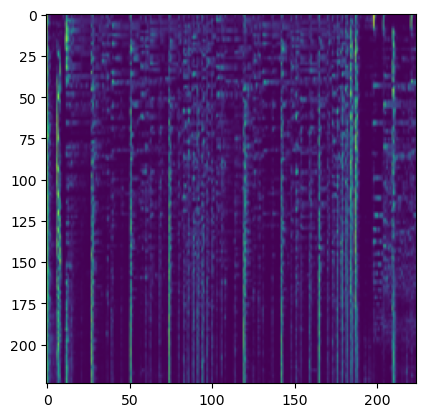

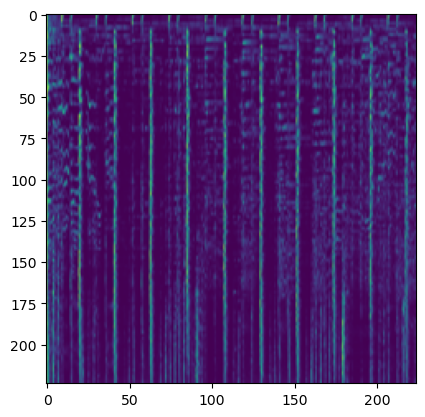

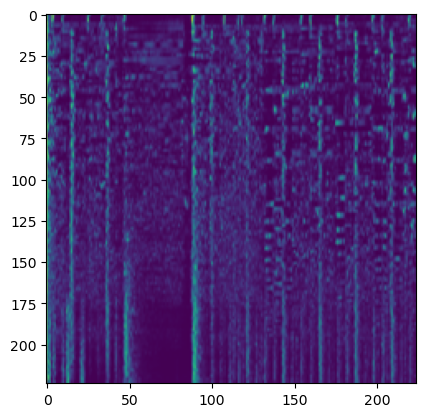

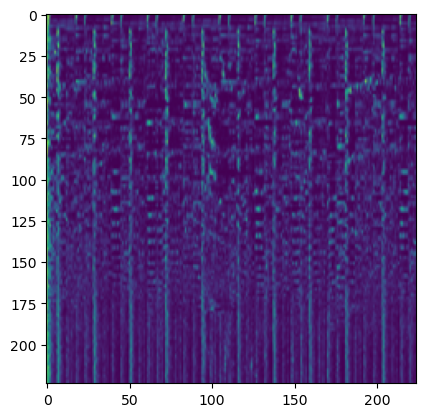

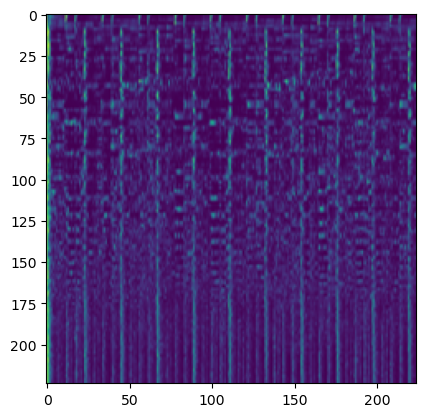

In [12]:
# Show the first few samples
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(means, sds)],
    std=[1/s for s in sds]
)

def show_image(img_tensor):
    img = inv_normalize(img_tensor)
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(np.clip(img, 0, 1))
    plt.show()

for i in range(5):
    image, label = train_dataset[i]
    show_image(image)

Let's now check the dataloader. We'll start by getting one batch.

Note that the iter() function returns an interator from an iterable (like a list, tuple, or PyTorch DataLoader)

The next() function gets the next item from an iterator

In [62]:
images, labels = next(iter(train_dataloader))
print(f"Image batch shape from train: {images.shape}")
print(f"Label batch shape from train: {labels.shape}")

Image batch shape from train: torch.Size([100, 3, 224, 224])
Label batch shape from train: torch.Size([100])


Check for errors while iterating.

We'll loop through a few batches to catch any file loading or transformation errors.

Note that train_dataloader is going to... re-create the batches each time it is called, so if you re-run the next code chunk the tensor labels will change

In [13]:
for i, (imgs, lbls) in enumerate(train_dataloader):
    print(f"Batch {i}: {imgs.shape}, {lbls}")
    if i == 2:  # only check the first 3 batches
        break

Batch 0: torch.Size([100, 3, 224, 224]), tensor([23, 12, 16, 15,  9, 13,  2, 17, 16, 22,  5,  5,  4, 19, 11, 12, 21, 10,
         4, 17, 16, 20, 28,  0,  0, 17, 14,  6, 12, 24,  1,  5,  6,  1,  1, 10,
         0, 22, 21, 20, 11, 23,  0,  2, 19, 22, 14, 16,  7, 14, 22,  7, 15, 10,
        18,  0,  2, 23, 20,  7, 20, 28, 11, 20,  7,  7,  6, 18,  0, 11,  2, 21,
         0, 23,  1,  1, 28, 23, 15,  4, 12,  7,  2, 13, 23, 12,  1,  2, 11, 13,
        18, 16,  6,  1,  4,  1,  6, 18,  7, 16])
Batch 1: torch.Size([100, 3, 224, 224]), tensor([ 9,  6,  7,  5,  7, 13,  2, 23, 12, 16, 10, 13, 20, 23, 16, 18,  9, 21,
        18, 14, 16,  6, 21, 24, 16,  4, 15, 21, 20, 12,  0, 28, 11,  2, 12,  7,
         0, 20, 17,  2, 28, 19, 13, 13, 13, 16,  7,  7, 11,  0,  6, 12, 24,  1,
         7, 11, 22,  1, 12, 15, 11,  7,  6,  7,  4,  1, 17, 16, 14, 18,  7,  5,
         4,  4, 21,  1,  1, 13,  0,  1, 21, 14,  2,  0, 19, 21,  6, 12,  7,  6,
         9,  9,  5, 23, 12, 12,  5, 23, 21, 20])
Batch 2: torch.Size(

<h2>Loading the Model</h2>

We'll load the ResNET50 model with pretrained weights and move it to the GPU.

We can examine the individual layers. There is a full description here: https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758/

The layers appear to be:
* model_resnet.layer4 (closest to output)
* model_resnet.layer3
* model_resnet.layer2
* model_resnet.layer1 (closest to input)

In [12]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model_resnet = torchvision.models.resnet50(weights='IMAGENET1K_V2')
model_resnet = model_resnet.to(device)

<h3>Link to Musicmap Genres</h3>

We'll replace the final layer in the resnet model with one that has output dimension equal to the number of genres in musicmap

In [13]:
# We'll need to update num_classes based on supergenre
num_classes = len(train_dataset.get_supergenre_names())
#num_classes = len(train_dataloader.dataset.classes)                     # Assuming you have train_dataloader already defined; could also set this manually

# If we don't need dropout, we can define the fc layer here:
#model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes).to(device)   # fc is the name of the final layer; move this to MPS

# If we want to use dropout to reduce overfitting, we can add it to fc here:
model_resnet.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(model_resnet.fc.in_features, num_classes)
).to(device)

# Next, make sure only fc is unfrozen
# Start by freezing all the layers
for param in model_resnet.parameters():
    param.requires_grad = False

# Unfreeze only the final classification head
for param in model_resnet.fc.parameters():
    param.requires_grad = True

<h3>Criterion</h3>

Set the criterion to crossentropyloss

In [14]:
#criterion_resnet = nn.CrossEntropyLoss()

# Could use label smoothing to prevent overconfidence during training
# 0.05 is "mild" smoothing
criterion_resnet = nn.CrossEntropyLoss(label_smoothing=0.05)

<h2>Fine-Tuning</h2>

A general description of the process is here: https://medium.com/@caterine/fine-tuning-a-model-using-pytorch-part-2-e86a548ac4fb

To do fine-tuning, we'll start by defining the optimizer only for the final (unfrozen) layer

In [15]:
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

Next, a helper function for doing the progressive unfreezing

In [16]:
# A function to unfreeze layers by name
def unfreeze_layers_by_name(model, layer_names):
    for name, module in model.named_children():
        #print("Model child name:", name)
        if name in layer_names:
            print(f"Unfreezing layer: {name}")
            for param in module.parameters():
                param.requires_grad = True



A helper function for computing top k accuracy

In [17]:
# A version revised to be idiomatic to pytorch
def top_k_accuracy(output, target, k=3):
    with torch.no_grad():
        _, pred = output.topk(k, dim=1)
        return (pred == target.unsqueeze(1)).any(dim=1).float().mean().item()

Set the number of epochs and "cutpoints" for the unfreezing

Note that unfreezing layers too early could contribute to overfitting

In [18]:
num_epochs = 20

# Keys are epoch numbers, values are tuples: (list_of_layers_to_unfreeze, new_learning_rate)
unfreeze_schedule = {
    0: (['fc'], 1e-3),
    5: (['layer4'], 1e-4),
    10: (['layer3'], 1e-5),
    15: (['layer2'], 1e-5),
}

Since evaluation currently involves a lot of metrics, we'll set it up as a separate function that can be called within each epoch.

In [20]:
# Evaluation function
# It takes the model, dataloader, criterion, device, shortest_graph, and epoch as inputs
# and returns a dictionary with evaluation metrics
# Note that this requires idx_to_supergenre array to have been defined in the training code
def evaluate(model, dataloader, criterion, device):#, shortest_graph, epoch=None):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.append(outputs)
            all_labels.append(labels)


    # Combine all predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    val_accuracy = correct / total
    avg_val_loss = val_loss / len(dataloader)

    # Move to CPU
    pred_classes = all_preds.argmax(dim=1).cpu()
    true_classes = all_labels.cpu()

    pred_classes_np = pred_classes.numpy()
    true_classes_np = true_classes.numpy()
    
    # Extract distances and compute mean (may include inf values)
#    distances = shortest_graph[pred_classes, true_classes]
#    mean_shortest_distance = distances.float().mean().item()

    # Supergenre metrics
#    pred_super = idx_to_supergenre[pred_classes_np]
#    true_super = idx_to_supergenre[true_classes_np]
#    supergenre_accuracy = np.mean(pred_super == true_super)

    # Top-3 supergenre accuracy
#    top3_indices = torch.topk(all_preds, k=3, dim=1).indices.cpu().numpy()
#    top3_supergenre_hits = sum(true_super[i] in idx_to_supergenre[top3] for i, top3 in enumerate(top3_indices))
#    supergenre_top3_accuracy = top3_supergenre_hits / len(true_super)

    # Standard classification metrics
    precision = precision_score(true_classes_np, pred_classes_np, average='macro', zero_division=0)
    recall = recall_score(true_classes_np, pred_classes_np, average='macro', zero_division=0)
    f1 = f1_score(true_classes_np, pred_classes_np, average='macro', zero_division=0)

    # Top-k accuracies
    top3_acc = top_k_accuracy(all_preds, all_labels, k=3)
    top5_acc = top_k_accuracy(all_preds, all_labels, k=5)

    # Save confusion matrix
    cm = confusion_matrix(true_classes_np, pred_classes_np)
    class_names = train_dataset.classes  # or provide manually if needed
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm_df.to_csv("confusion_matrix.csv")

    # Return all metrics as a dictionary
    return {
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy,
        "top3_accuracy": top3_acc,
        "top5_accuracy": top5_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    #    "mean_distance": mean_shortest_distance,
    #    "supergenre_accuracy": supergenre_accuracy,
    #    "supergenre_top3_accuracy": supergenre_top3_accuracy
    }

In [21]:
# Create index-to-supergenre lookup once
idx_to_supergenre = np.array([cls[:3] for cls in train_dataset.classes])  # shape (num_classes,)

# Metric lists
val_accuracy_list = []
top3_acc_list = []
top5_acc_list = []
precision_list = []
recall_list = []
f1_list = []
#mean_dist_list = []
#super_acc_list = []
#super_top3_acc_list = []
train_loss_list = []
train_accuracy_list = []
val_loss_list = []

# === Training Loop ===
for epoch in range(num_epochs):
    if epoch in unfreeze_schedule:
        layers_to_unfreeze, lr = unfreeze_schedule[epoch]
        unfreeze_layers_by_name(model_resnet, layers_to_unfreeze)
        optimizer_resnet = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model_resnet.parameters()),
            lr=lr
        )

    # --- Training ---
    model_resnet.train()
    train_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch+1} - Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_resnet.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = correct / total

    # --- Validation ---
    metrics = evaluate(model_resnet, val_dataloader, criterion_resnet, device)#, shortest_graph)#, epoch=epoch)

    # Append metrics to lists
    for lst, key in zip(
        [val_loss_list, val_accuracy_list, top3_acc_list, top5_acc_list, precision_list, recall_list, f1_list],
        #mean_dist_list,         super_acc_list, super_top3_acc_list],
        ["val_loss", "val_accuracy", "top3_accuracy", "top5_accuracy", "precision", "recall", "f1"]
        #"mean_distance",         "supergenre_accuracy", "supergenre_top3_accuracy"]
    ):
        lst.append(metrics[key])

    # Print metrics table
    headers = ["Epoch", "Train Loss", "Train Acc", "Val Loss", "Val Acc",
               "Top-3 Acc", "Top-5 Acc", "Precision", "Recall", "F1"]
               #"Supergenre Acc", "Top-3 Super"]#, "Mean Dist"]

    row = [epoch + 1,
        f"{avg_train_loss:.4f}", f"{train_accuracy:.2%}",
        f"{metrics['val_loss']:.4f}", f"{metrics['val_accuracy']:.2%}",
        f"{metrics['top3_accuracy']:.2%}", f"{metrics['top5_accuracy']:.2%}",
        f"{metrics['precision']:.2%}", f"{metrics['recall']:.2%}", f"{metrics['f1']:.2%}"]
        #f"{metrics['supergenre_accuracy']:.2%}", f"{metrics['supergenre_top3_accuracy']:.2%}",
    #    f"{metrics['mean_distance']:.4f}"]

    print(tabulate([row], headers=headers, tablefmt="grid"))

Unfreezing layer: fc


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|       1 |        2.853 | 20.02%      |     2.7328 | 23.93%    | 46.97%      | 60.12%      | 21.83%      | 16.53%   | 14.14% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|       2 |       2.5514 | 28.48%      |     2.6684 | 24.61%    | 49.13%      | 62.09%      | 19.61%      | 17.57%   | 15.63% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|       3 |        2.421 | 32.23%      |     2.6321 | 25.21%    | 49.84%      | 63.95%      | 20.71%      | 18.57%   | 17.57% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|       4 |       2.3369 | 34.92%      |     2.6269 | 25.49%    | 50.10%      | 63.84%      | 21.13%      | 19.37%   | 18.39% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|       5 |       2.2661 | 37.25%      |     2.6108 | 26.34%    | 51.17%      | 64.59%      | 21.59%      | 19.76%   | 18.77% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
Unfreezing layer: layer4


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|       6 |       2.0428 | 44.10%      |     2.5247 | 28.46%    | 55.55%      | 69.34%      | 23.91%      | 22.92%   | 22.37% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|       7 |       1.4774 | 65.71%      |     2.6088 | 28.52%    | 53.92%      | 68.23%      | 24.47%      | 23.48%   | 23.27% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|       8 |       1.0101 | 84.04%      |     2.7269 | 28.16%    | 53.58%      | 67.44%      | 24.39%      | 23.51%   | 23.43% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|       9 |       0.6892 | 95.45%      |     2.8578 | 27.15%    | 51.19%      | 65.92%      | 23.16%      | 22.17%   | 22.18% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|      10 |       0.5418 | 98.86%      |     2.9193 | 26.73%    | 50.40%      | 63.69%      | 22.67%      | 22.59%   | 22.34% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
Unfreezing layer: layer3


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|      11 |       0.4742 | 99.79%      |     2.8857 | 27.13%    | 49.67%      | 62.75%      | 23.26%      | 23.04%   | 22.93% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|      12 |        0.458 | 99.89%      |      2.885 | 26.43%    | 49.01%      | 61.88%      | 22.48%      | 22.47%   | 22.30% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|      13 |       0.4482 | 99.97%      |     2.8779 | 26.92%    | 48.90%      | 62.09%      | 22.86%      | 22.84%   | 22.69% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|      14 |       0.4391 | 99.97%      |     2.8884 | 26.47%    | 48.69%      | 61.71%      | 22.57%      | 22.53%   | 22.36% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|      15 |       0.4342 | 99.98%      |     2.9045 | 26.30%    | 48.15%      | 60.27%      | 22.17%      | 22.47%   | 22.16% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
Unfreezing layer: layer2


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|      16 |       0.4291 | 99.98%      |     2.8936 | 26.23%    | 48.13%      | 60.55%      | 22.26%      | 22.43%   | 22.14% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|      17 |       0.4242 | 99.99%      |      2.887 | 26.56%    | 48.39%      | 60.25%      | 22.48%      | 22.63%   | 22.36% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|      18 |       0.4195 | 99.99%      |      2.888 | 26.71%    | 47.96%      | 59.85%      | 22.77%      | 22.96%   | 22.67% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|      19 |       0.4153 | 99.99%      |     2.8874 | 26.30%    | 47.59%      | 59.48%      | 22.20%      | 22.32%   | 22.06% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1     |
+=========+==============+=============+============+===========+=============+=============+=============+==========+========+
|      20 |       0.4127 | 100.00%     |     2.8906 | 26.58%    | 47.44%      | 59.10%      | 22.89%      | 22.92%   | 22.68% |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+--------+


Next we'll do the plotting

In [30]:
# Plot the confusion matrix heatmap

import seaborn as sns

# Load cm_df from the csv confusion_matrix.csv
cm_df = pd.read_csv("confusion_matrix.csv", index_col=0)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df.div(cm_df.sum(axis=1), axis=0), annot=True, fmt=".2f", cmap="Blues", square=True, cbar=True)
#sns.heatmap(super_cm_df, annot=True, fmt="d", cmap="Blues", square=True, cbar=False)
plt.title("Supergenre Confusion Matrix")
plt.ylabel("True Supergenre")
plt.xlabel("Predicted Supergenre")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("confusion_matrix_supergenre.png")
plt.close()

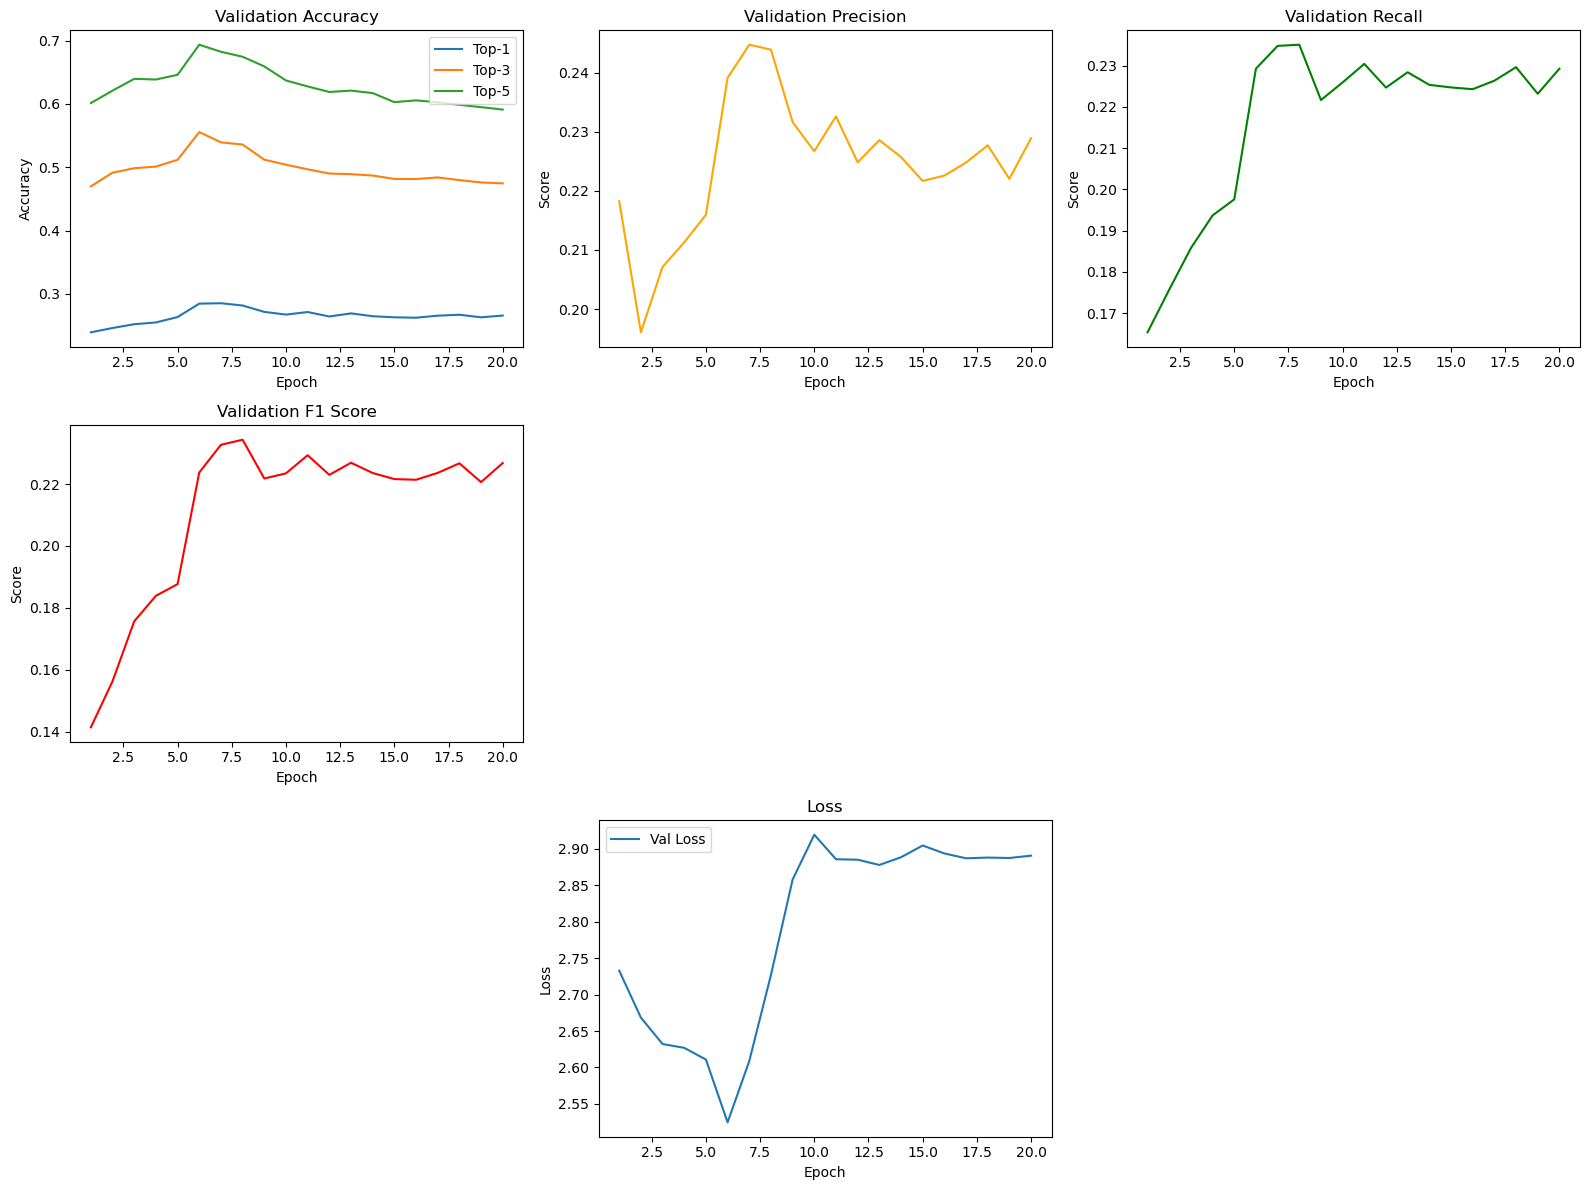

In [23]:

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(16, 12))

# Validation Accuracy
plt.subplot(3, 3, 1)
plt.plot(epochs, val_accuracy_list, label='Top-1')
plt.plot(epochs, top3_acc_list, label='Top-3')
plt.plot(epochs, top5_acc_list, label='Top-5')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3, 3, 2)
plt.plot(epochs, precision_list, label='Precision', color='orange')
plt.title('Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Score')

# Recall
plt.subplot(3, 3, 3)
plt.plot(epochs, recall_list, label='Recall', color='green')
plt.title('Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')

# F1 Score
plt.subplot(3, 3, 4)
plt.plot(epochs, f1_list, label='F1 Score', color='red')
plt.title('Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')

# Mean Shortest Distance
#plt.subplot(3, 3, 5)
#plt.plot(epochs, mean_dist_list, label='Mean Shortest Distance', color='blue')
#plt.title('Mean Shortest Distance')
#plt.xlabel('Epoch')
#plt.ylabel('Distance')

# Supergenre Accuracy
#plt.subplot(3, 3, 6)
#plt.plot(epochs, super_acc_list, label='Supergenre Accuracy', color='purple')
#plt.title('Supergenre Accuracy')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')

# Top-3 Supergenre Accuracy
#plt.subplot(3, 3, 7)
#plt.plot(epochs, super_top3_acc_list, label='Top-3 Supergenre Accuracy', color='brown')
#plt.title('Top-3 Supergenre Accuracy')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')

# Train and Val Loss
plt.subplot(3, 3, 8)
#plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Train Accuracy
#plt.subplot(3, 3, 9)
#plt.plot(epochs, train_accuracy_list, label='Train Accuracy', color='cyan')
#plt.title('Train Accuracy')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

If things look good, we can save the weights

In [25]:
torch.save(model_resnet.state_dict(), 'resnet_15sec_augmented_supergenres.pth')